# Prototyping the Multi Input Model

In [1]:
import tensorflow as tf

### Houskeeping

In [2]:
tf.__version__


'2.4.1'

In [3]:

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
# import the necessary packages
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop



In [5]:


import glob
import numpy as np
# import csv
from itertools import compress
import rasterio
import random
import json
import math
import time
import os
import sys
import pandas as pd
# Self written functions
from helpers.helpers_read_data import *
# from helpers.helpers_models_tf2 import *
# from helpers.helpers_performance_analytics import *



## Adapting the reading of the satellite images

In [6]:
images_path = '/Users/haui/Desktop/Kenya_Landsat7_1y_before_election_scale30'
# images_path = '/Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/data/landsat7_temp'
ps_data_path = '/Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/data/kenya13_vars.json'

image_data, image_ps_id = read_stllt_images_and_names(images_path)

In [7]:
len(image_data)

24599

In [8]:
# 1 Prepare data dictionaries for easy querying
# Images dict at PS level
images_data_dict = dict(zip(image_ps_id,image_data))

In [131]:
# Let us use the same data as for the DNN
raw_dat = pd.read_csv('../data/final-for-analysis.csv')

dat = pd.concat([raw_dat['psid'],
                 # turnout
                 raw_dat["turnout_count"], raw_dat["registered_voters"], 
                 # ethnic frac (let's simply average...)
                 raw_dat['ethnic_frac'],
                 # other PS level data
                 raw_dat['terrain_elevation'], raw_dat['terrain_ruggedness'],
                   raw_dat['terrain_slope'],raw_dat['poverty_rate'], raw_dat['literacy_rate'],
                   raw_dat['dependency_ratio'],raw_dat['skilled_birth_att'],
                   raw_dat['night_lights'],raw_dat['county_name']], axis=1)


dat_ps = dat.groupby('psid').agg({
    # preparing for turnout
    'turnout_count': 'sum',
    'registered_voters': 'sum',
    # assumption. but fair approx for now, since all streams have (sort of) same weight
    'ethnic_frac': 'mean',
    # Polling Station level anyway
    'terrain_elevation': 'first',
    'terrain_ruggedness': 'first',
    'terrain_slope': 'first',
    'poverty_rate': 'first',
    'literacy_rate': 'first',
    'dependency_ratio': 'first',
    'skilled_birth_att': 'first',
    'night_lights': 'first',
    'county_name': 'first',
})



/Users/haui/anaconda3/envs/tf2_vi/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [132]:
dat_ps.head()
# dat_ps.tail() TODO there is something weird happening

,turnout_count,registered_voters,ethnic_frac,terrain_elevation,terrain_ruggedness,terrain_slope,poverty_rate,literacy_rate,dependency_ratio,skilled_birth_att,night_lights,county_name
psid,,,,,,,,,,,,
001/001,3369.0,5267.0,0.559003,-2.196058,-0.752885,-0.756035,-2.109904,6.377350,-2.322930,0.612534,3.677581,MOMBASA
001/002,2354.0,3489.0,0.662413,-2.205743,-0.794555,-0.788982,-2.179095,6.078287,-2.455718,0.615652,3.662392,MOMBASA
001/003,1295.0,2277.0,0.654413,-2.207539,-0.737618,-0.740169,-2.209238,6.424049,-2.455718,0.614910,3.678592,MOMBASA
001/004,1751.0,2337.0,0.556684,-2.203868,-0.768254,-0.770896,-2.199451,6.468515,-2.455718,0.614704,3.686981,MOMBASA
001/005,1070.0,1448.0,0.500205,-2.203344,-0.669685,-0.670843,-2.201605,6.475418,-2.455718,0.613048,3.692524,MOMBASA


#### Clean data 

In [133]:
# turn rown names from grouping into own column
dat_ps.index.name = 'psid'
dat_ps.reset_index(inplace=True)
# replace the / for a - to be in sync with the image names
dat_ps['psid'] = dat_ps['psid'].str.replace('/','-')

In [134]:
# calculate and correct turnout
dat_ps['registered_voters'] = dat_ps['registered_voters'].replace(0, np.NaN)
dat_ps['turnout'] = dat_ps["turnout_count"]/dat_ps['registered_voters']
dat_ps['turnout'].values[dat_ps['turnout'] > 1] = np.NaN
# drop NaNs
dat_ps = dat_ps.dropna()
# turn into dictionary for polling stations
# ps_data_dict = dict(zip(list(dat_ps['psid']), list(dat_ps['turnout'])))
# 
dat_ps = pd.get_dummies(dat_ps, columns=['county_name'], prefix='', prefix_sep='')



In [135]:
dat_ps.shape


(22008, 60)

In [136]:
# # Data Checks
dat_ps.head()
max(dat_ps['turnout'])
min(dat_ps['turnout'])

0.01824817518248175

#### Make sure each data point is only covered once and that we have data for it
* In the polling station data check for double entries 
* Do we have data for the sat image?


In [137]:
unique_ps_id = list(set(list(dat_ps['psid'])))
# assert each id occurs only once
assert len(unique_ps_id)==dat_ps.shape[0]

ps_id_at_ps_level = list(dat_ps['psid'])
# turnout_at_ps_level = list(dat_ps['turnout'])


## Split up the three data sources -- in the correct order
* ID vars are in: ps_id_at_ps_level_wona
* images are in: images_at_ps_level_wona
* outcome var is in: turnout_at_ps_level_wona
* further EVs are in: dat_ps_features_wona


In [138]:
# This creates a mask to check for which satellite images we actually have data. 
# Returns 
# a) a list with the photos of the polling stations for which there are data 
# b) And a mask that you can use to select later on
images_at_ps_level_wona = []
mask = [True]*len(ps_id_at_ps_level)

In [139]:
# this is a name query in the order of the ps_ids in the dat_ps data set
# in result, the sat images are queried from the images_data_dict dictionary in the same order as dat_ps
for i in range(len(ps_id_at_ps_level)):
    try:
        images_at_ps_level_wona.append(images_data_dict[ps_id_at_ps_level[i]])
    except:
        mask[i] = False

In [140]:
# keeps those data for which we also have a sat image
dat_ps_wona = dat_ps[mask]

In [141]:
print('We do not have data for',len(ps_id_at_ps_level) - len(images_at_ps_level_wona),'sat images. \n')

We do not have data for 6 sat images. 



In [142]:
# this generates the data we need for the model
dat_ps_features_wona = dat_ps_wona.copy()
turnout_at_ps_level_wona = list(dat_ps_features_wona.pop('turnout'))
ps_id_at_ps_level_wona = list(dat_ps_features_wona.pop('psid'))

Now: also kick out the data that would give away the turnout

In [143]:
turnout_count_at_ps_level_wona = list(dat_ps_features_wona.pop('turnout_count'))
registered_voters_at_ps_level_wona = list(dat_ps_features_wona.pop('registered_voters'))


In [144]:
assert (dat_ps_features_wona.shape[0] == len(ps_id_at_ps_level_wona) == 
        len(images_at_ps_level_wona) == len(turnout_at_ps_level_wona)), 'Something went wrong in the data generation. There are different lengths'

### Splitting the train test set

In [145]:
# defines the new random order
new_order = random.sample(range(len(turnout_at_ps_level_wona)), len(turnout_at_ps_level_wona))

In [146]:
# defines train-test-val size
observed_ps_set_size = len(turnout_at_ps_level_wona)
testval_set_size = math.floor(.1*observed_ps_set_size)
# train_set_size = observed_ps_set_size - 2*testval_set_size
train_set_size = observed_ps_set_size - testval_set_size

In [147]:
# reshape images
image_data_all_bands = np.stack(images_at_ps_level_wona, axis = 0)

In [148]:
image_data_all_bands = image_data_all_bands.reshape((observed_ps_set_size, 96, 96, 7))

#### train val test sat images

In [149]:
train_images = image_data_all_bands[new_order[0:train_set_size],:,:,:].reshape(train_set_size, 96, 96, 7)
# split in this way because validation taken in on the fly in model.fit()
# val_images = image_data_all_bands[new_order[train_set_size:(train_set_size+testval_set_size)],:,:,:].reshape((testval_set_size, 96, 96, 7))
# test_images = image_data_all_bands[new_order[(train_set_size+testval_set_size):observed_ps_set_size],:,:,:].reshape((testval_set_size, 96, 96, 7))
test_images = image_data_all_bands[new_order[train_set_size:observed_ps_set_size],:,:,:].reshape((testval_set_size, 96, 96, 7))

#### train val test ps data

In [150]:
train_ps_data = np.array(dat_ps_features_wona)[new_order[0:train_set_size],:]
# val_ps_data = np.array(dat_ps_features_wona)[new_order[train_set_size:(train_set_size+testval_set_size)],:]
# test_ps_data = np.array(dat_ps_features_wona)[new_order[(train_set_size+testval_set_size):observed_ps_set_size],:]
test_ps_data = np.array(dat_ps_features_wona)[new_order[train_set_size:observed_ps_set_size],:]

In [151]:
# normalise the data
normalizer = Normalization()
normalizer.adapt(np.array(train_ps_data))

In [152]:
train_ps_data_normalized =normalizer(train_ps_data)
# val_ps_data_normalized =normalizer(val_ps_data)
# test_ps_data_normalized =normalizer(test_ps_data)

#### train val test labels

In [153]:
train_labels = np.array([turnout_at_ps_level_wona[i] for i in new_order[0:train_set_size]])
# val_labels = [turnout_at_ps_level_wona[i] for i in new_order[train_set_size:(train_set_size+testval_set_size)]]
# test_labels = np.array([turnout_at_ps_level_wona[i] for i in new_order[(train_set_size+testval_set_size):observed_ps_set_size]])
test_labels = np.array([turnout_at_ps_level_wona[i] for i in new_order[train_set_size:observed_ps_set_size]])

In [154]:
# Assert labels and data have same length
assert(train_ps_data.shape[0] == len(train_labels))
# assert(val_ps_data.shape[0] == len(val_labels))
assert(test_ps_data.shape[0] == len(test_labels))

In [156]:
# save the ids
# e.g. to write the train_val_test split as json for eventual later use
train_ps_id = [ps_id_at_ps_level_wona[i] for i in new_order[0:train_set_size]]
# val_ps_id = [ps_id_at_ps_level_wona[i] for i in new_order[train_set_size:(train_set_size+testval_set_size)]]
test_ps_id = [ps_id_at_ps_level_wona[i] for i in new_order[train_set_size:observed_ps_set_size]]

# Define the Model

## Toy Model for Testing

In [157]:
# TODO batch normalisation
inputs_img = keras.Input(shape=(96,96,7))
x = Conv2D(32, kernel_size=(3,3),padding='same', activation='relu')(inputs_img)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x) 
x = Conv2D(64, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x) 
# x = Conv2D(128, kernel_size=(3,3),padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x) 
x = Flatten()(x)
x = Dense(8, activation = 'relu')(x)



In [158]:
inputs_ps_dat = keras.Input(shape=(58,))
y = Dense(64, activation="relu")(inputs_ps_dat)
y = Dense(32, activation="relu")(y)
y = Dense(8, activation="linear")(y)

In [159]:
combined_input = concatenate([x, y])

In [160]:
# trial
z = Dense(4, activation="relu")(combined_input)
z = Dense(1, activation="sigmoid")(z)
toy_model = Model(inputs=[inputs_img, inputs_ps_dat], outputs=z)

In [161]:
print(toy_model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 96, 96, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 96, 96, 32)   2048        input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 48, 48, 32)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 48, 48, 32)   128         max_pooling2d_16[0][0]           
____________________________________________________________________________________________

## Deployment

## Images Strand


In [162]:
# Deep Model

inputs_img = keras.Input(shape=(96,96,7))
# Conv Block 1
x = Conv2D(64, kernel_size=(3,3),padding='same', activation='relu')(inputs_img)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x) 
# Conv Block 2
x = Conv2D(128, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
# x = Conv2D(128, kernel_size=(3,3),padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# Conv Block 3
x = Conv2D(256, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
# Conv Block 4
x = Conv2D(256, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
# Conv Block 5
x = Conv2D(512, kernel_size=(3,3),padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
# Flatten and dense
x = Flatten()(x)
# x = Dense(16)(x)
# x = Activation("relu")(x)
# x = BatchNormalization(axis=-1)(x)
# x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)


In [163]:
# model_img_data = Model(inputs_img, x)
# print(model_img_data.summary())

In [164]:
# model_img_data = Model(inputs, x)
# print(model_img_data.summary())
# plot_model(model_img_data)
# TODO


## Data Strand


In [165]:
inputs_ps_dat = keras.Input(shape=(56,))
y = Dense(64, activation="relu")(inputs_ps_dat)
y = Dense(64, activation="relu")(y)
y = Dense(32, activation="linear")(y)

In [166]:
# model_ps_data = Model(inputs, y)
# print(model_ps_data.summary())


## Join the Strands 


In [167]:
combined_input = concatenate([x, y])

In [168]:
z = Dense(128, activation="relu")(combined_input)
z = Dropout(0.4)(z)
z = Dense(32, activation="relu")(combined_input)
z = Dense(1, activation="sigmoid")(z)
model = Model(inputs=[inputs_img, inputs_ps_dat], outputs=z)

In [170]:
print(model.summary())
# plot_model(model)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 96, 96, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 96, 96, 64)   4096        input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 48, 48, 64)   0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 48, 48, 64)   256         max_pooling2d_19[0][0]           
____________________________________________________________________________________________

# Running

In [171]:
# switch for local trial runs 
# model = toy_model


## Compile



In [172]:
# set paths
best_model_path = '/Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_multi_input.h5'
log_dir = 'logs/'

In [173]:
# define callbacks
# select best models, but with early stopping
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10,
    mode='min', min_delta=0.0001)
# save best model for fit later
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_path, monitor='val_mae', verbose=1,
    save_best_only=True, mode='min')
# tensorboard callbacks for debugging
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [early_stopper, checkpoint, tensorboard_callback]


In [174]:
# from https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
opt = Adam()
# opt = RMSprop()
model.compile(loss='mse',
             metrics=['mae'],
             optimizer=opt)

## Train 

In [175]:
history = model.fit(
    x=[train_images, train_ps_data_normalized], y=train_labels,
    validation_split=0.1, callbacks=callbacks_list,
    epochs=100, batch_size=64)
# history = model.fit(
#     x=[train_images, train_ps_data_normalized], y=train_labels,
#     validation_data=([val_images, val_ps_data_normalized], val_labels),
#     callbacks=callbacks_list,
#     epochs=100, batch_size=64)

Epoch 1/100
279/279 [==============================] - 350s 1s/step - loss: 0.0304 - mae: 0.1174 - val_loss: 0.0729 - val_mae: 0.2492

Epoch 00001: val_mae improved from inf to 0.24919, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_multi_input.h5
Epoch 2/100
279/279 [==============================] - 314s 1s/step - loss: 0.0060 - mae: 0.0492 - val_loss: 0.0067 - val_mae: 0.0604

Epoch 00002: val_mae improved from 0.24919 to 0.06035, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_multi_input.h5
Epoch 3/100
279/279 [==============================] - 310s 1s/step - loss: 0.0041 - mae: 0.0410 - val_loss: 0.0040 - val_mae: 0.0400

Epoch 00003: val_mae improved from 0.06035 to 0.03998, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_multi

In [179]:
model.predict([test_images, normalizer(test_ps_data)])

array([[0.83246994],
       [0.8954464 ],
       [0.75124824],
       ...,
       [0.70831585],
       [0.8443536 ],
       [0.8600651 ]], dtype=float32)

In [176]:
test_predictions = model.predict([test_images, normalizer(test_ps_data)]).flatten()


In [178]:
errors = abs(test_predictions - test_labels)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4))

Mean Absolute Error: 0.0395


In [177]:
model.evaluate([test_images, normalizer(test_ps_data)], test_labels, verbose=0)

[0.00387154845520854, 0.039507102221250534]

In [180]:
min(test_predictions)
# max(test_labels)

0.5994992

In [181]:
test_predictions

array([0.83246994, 0.8954464 , 0.75124824, ..., 0.70831585, 0.8443536 ,
       0.8600651 ], dtype=float32)

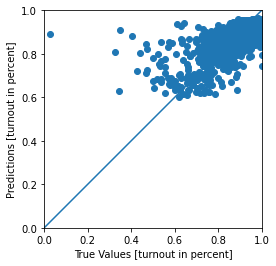

In [182]:
import matplotlib.pyplot as plt
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [turnout in percent]')
plt.ylabel('Predictions [turnout in percent]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [94]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [95]:
%tensorboard --logdir logs/

In [183]:

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, .004])
  plt.xlabel('Epoch')
  plt.ylabel('Error [percentage]')
  plt.legend()
  plt.grid(True)

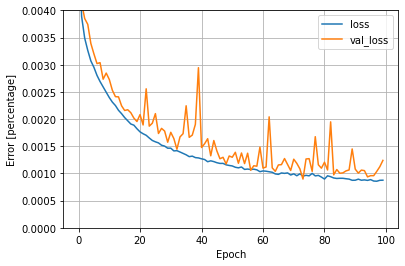

In [204]:
plot_loss(history)

In [41]:
network = model1()

In [42]:
optimizer = RMSprop()

In [43]:
network.compile(optimizer=optimizer,
                    loss='mse',
                    metrics=['mae'])


In [44]:
best_model_path = '/Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_ps_level.h5'
# select best models, but with early stopping
early_stopper = EarlyStopping(monitor='val_mae', patience=25,
    mode='min', min_delta=0.0001)
checkpoint = ModelCheckpoint(best_model_path, monitor='val_mae', verbose=1,
    save_best_only=True, mode='min')
callbacks_list = [early_stopper, checkpoint]


In [45]:

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Train

In [46]:
# do the work
history = network.fit(train_images, train_labels,
            epochs=100 , batch_size=16, callbacks=callbacks_list,
            validation_data=(val_images, val_labels))



Train on 18195 samples, validate on 2274 samples
Epoch 1/100
18195/18195 [==============================] - 199s 11ms/step - loss: 0.0261 - mae: 0.1257 - val_loss: 0.0092 - val_mae: 0.0639

Epoch 00001: val_mae improved from inf to 0.06386, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_ps_level.h5
Epoch 2/100
18195/18195 [==============================] - 129s 7ms/step - loss: 0.0120 - mae: 0.0768 - val_loss: 0.0077 - val_mae: 0.0575

Epoch 00002: val_mae improved from 0.06386 to 0.05751, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_local/vi_satellites_dev/code_sandbox_ca/best_models/temp_ps_level.h5
Epoch 3/100
18195/18195 [==============================] - 125s 7ms/step - loss: 0.0086 - mae: 0.0657 - val_loss: 0.0072 - val_mae: 0.0562

Epoch 00003: val_mae improved from 0.05751 to 0.05625, saving model to /Users/haui/Dropbox/Academia/Projects/voting_irregularities_lo

18195/18195 [==============================] - 145s 8ms/step - loss: 0.0052 - mae: 0.0488 - val_loss: 0.0064 - val_mae: 0.0548

Epoch 00034: val_mae did not improve from 0.04611
Epoch 35/100
18195/18195 [==============================] - 145s 8ms/step - loss: 0.0053 - mae: 0.0488 - val_loss: 0.0072 - val_mae: 0.0611

Epoch 00035: val_mae did not improve from 0.04611
Epoch 36/100
18195/18195 [==============================] - 146s 8ms/step - loss: 0.0052 - mae: 0.0484 - val_loss: 0.0088 - val_mae: 0.0637

Epoch 00036: val_mae did not improve from 0.04611
Epoch 37/100
18195/18195 [==============================] - 146s 8ms/step - loss: 0.0050 - mae: 0.0479 - val_loss: 0.0090 - val_mae: 0.0646

Epoch 00037: val_mae did not improve from 0.04611
Epoch 38/100
18195/18195 [==============================] - 147s 8ms/step - loss: 0.0049 - mae: 0.0475 - val_loss: 0.0070 - val_mae: 0.0536

Epoch 00038: val_mae did not improve from 0.04611
Epoch 39/100
18195/18195 [==============================] 

In [49]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, .05])
  plt.xlabel('Epoch')
  plt.ylabel('Error [percentage]')
  plt.legend()
  plt.grid(True)


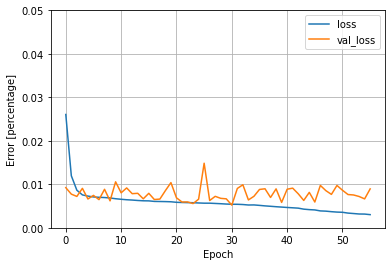

In [50]:
plot_loss(history)

In [54]:
network.load_weights(best_model_path)


In [56]:

network.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae'])



In [57]:
predicted_score = network.predict(test_images)

In [58]:
predicted_score

array([[0.84731066],
       [0.9111533 ],
       [0.8853828 ],
       ...,
       [0.887815  ],
       [0.9202273 ],
       [0.71072334]], dtype=float32)

In [59]:
results = network.evaluate(test_images, test_labels)

2274/2274 [==============================] - 4s 2ms/step


In [60]:
print("test loss, test MAE:", results)


test loss, test MAE: [0.006271494327751115, 0.05192096158862114]


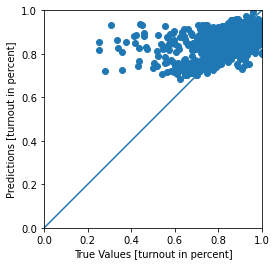

In [61]:
test_predictions = network.predict(test_images)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [turnout in percent]')
plt.ylabel('Predictions [turnout in percent]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### OOS Prediction